# Start-to-Finish Example: Setting up Two Black Hole Initial Data, in Curvilinear Coordinates

## This module sets up initial data for a merging black hole system in *spherical coordinates*

<font color='green'>**This module has been validated to exhibit convergence to zero of the Hamiltonian constraint violation at the expected order to the exact solution (see plot at bottom), and all quantities have been validated against the [original SENR code](https://bitbucket.org/zach_etienne/nrpy).**</font>

### NRPy+ Source Code for this module: [BSSN/BSSN_RHSs.py](../edit/BSSN/BSSN_RHSs.py), [BSSN/BSSN_Constraints.py](../edit/BSSN/BSSNConstraints.py)


Here we use NRPy+ to generate initial data for two black holes (Brill-Lindquist, [Brill & Lindquist, Phys. Rev. 131, 471, 1963](https://journals.aps.org/pr/abstract/10.1103/PhysRev.131.471); see also Eq. 1 of [Brandt & Brügmann, arXiv:gr-qc/9711015v1](https://arxiv.org/pdf/gr-qc/9711015v1.pdf)).

[//]: # " and then we use it to generate the RHS expressions for [Method of Lines](https://reference.wolfram.com/language/tutorial/NDSolveMethodOfLines.html) time integration based on the [explicit Runge-Kutta fourth-order scheme](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods) (RK4)."

The entire algorithm is outlined below, with NRPy+-based components highlighted in <font color='green'>green</font>.

1. Allocate memory for gridfunctions, including temporary storage for the RK4 time integration.
1. <font color='green'>Set gridfunction values to initial data (**This module**).</font>
1. Evolve the system forward in time using RK4 time integration. At each RK4 substep, do the following:
    1. <font color='green'>Evaluate BSSN RHS expressions.</font>
    1. Apply singular, curvilinear coordinate boundary conditions [*a la* the SENR/NRPy+ paper](https://arxiv.org/abs/1712.07658)
    1. <font color='green'>Apply constraints on conformal 3-metric: $\det{\bar{\gamma}_{ij}}=\det{\hat{\gamma}_{ij}}$</font>
1. At the end of each iteration in time, output the <font color='green'>Hamiltonian constraint violation</font>.
1. Repeat above steps at two numerical resolutions to confirm convergence to zero.

## Setting up the initial data

### Brill-Lindquist initial data ([Brill & Lindquist, Phys. Rev. 131, 471, 1963](https://journals.aps.org/pr/abstract/10.1103/PhysRev.131.471); see also Eq. 1 of [Brandt & Brügmann, arXiv:gr-qc/9711015v1](https://arxiv.org/pdf/gr-qc/9711015v1.pdf)) may be written in terms of the BSSN conformal factor and ADM extrinsic curvature as

$$\psi = e^{\phi} = 1 + \sum_{i=1}^N \frac{m_{(i)}}{2 \left|\vec{r}_{(i)} - \vec{r}\right|};\quad K_{ij}=0.$$

These data consist of $N$ nonspinning black holes initially at rest. This module restricts to the case of two such black holes, positioned along either the $x$ or $z$ axis. Here, we implement $N=2$.

**Inputs for $\psi$**:
* The position and (bare) mass of black hole 1: $\left(x_{(1)},y_{(1)},z_{(1)}\right)$ and $m_{(1)}$, respectively
* The position and (bare) mass of black hole 2: $\left(x_{(2)},y_{(2)},z_{(2)}\right)$ and $m_{(2)}$, respectively

**Additional variables needed for spacetime evolution**:
* Desired coordinate system
* Desired initial lapse $\alpha$ and shift $\beta^i$

**Transformation to curvilinear coordinates**:
* Once the above variables have been set in Cartesian coordinates, we will apply the appropriate coordinate transformations and tensor rescalings ([described in the BSSN NRPy+ tutorial module](Tutorial-BSSNCurvilinear.ipynb))

In [1]:
# Step P0: Load needed modules
import sympy as sp
import NRPy_param_funcs as par
import indexedexp as ixp
import grid as gri
from outputC import *
import reference_metric as rfm
import BSSN.BSSN_RHSs

# Step P1: Set up reference metric
# Step P1a: Choose SinhSpherical coordinates
#CoordSystem = "SinhSpherical"
CoordSystem = "Spherical"
par.set_parval_from_str("reference_metric::CoordSystem",CoordSystem)
# Step P1b: Set up needed reference metric quantities
rfm.reference_metric()

thismodule = "Brill-Lindquist"
BH1_posn_x,BH1_posn_y,BH1_posn_z = par.Cparameters("REAL", thismodule, ["BH1_posn_x","BH1_posn_y","BH1_posn_z"])
BH1_mass = par.Cparameters("REAL", thismodule, ["BH1_mass"])
BH2_posn_x,BH2_posn_y,BH2_posn_z = par.Cparameters("REAL", thismodule, ["BH2_posn_x","BH2_posn_y","BH2_posn_z"])
BH2_mass = par.Cparameters("REAL", thismodule, ["BH2_mass"])

# Step 0: Set spatial dimension (must be 3 for BSSN)
DIM = 3
par.set_parval_from_str("grid::DIM",DIM)

Cartxyz = ixp.declarerank1("Cartxyz")

# Step 1: Set psi, the conformal factor:
psi = sp.sympify(1)
psi += BH1_mass / ( 2 * sp.sqrt((Cartxyz[0]-BH1_posn_x)**2 + (Cartxyz[1]-BH1_posn_y)**2 + (Cartxyz[2]-BH1_posn_z)**2) )
psi += BH2_mass / ( 2 * sp.sqrt((Cartxyz[0]-BH2_posn_x)**2 + (Cartxyz[1]-BH2_posn_y)**2 + (Cartxyz[2]-BH2_posn_z)**2) )
    
# Step 2: Set all needed ADM variables in Cartesian coordinates
gammaCartDD = ixp.zerorank2()
KCartDD     = ixp.zerorank2() # K_{ij} = 0 for these initial data
for i in range(DIM):
    gammaCartDD[i][i] = psi**4

alphaCart = 1/psi**2
betaCartU = ixp.zerorank1() # We generally choose \beta^i = 0 for these initial data
BCartU    = ixp.zerorank1() # We generally choose B^i = 0 for these initial data

Next we convert these ADM variables 

$$\left\{\gamma_{ij}, K_{ij}, \alpha, \beta^i\right\}$$

to the BSSN variables

$$\left\{\bar{\gamma}_{i j},\bar{A}_{i j},\phi, K, \bar{\Lambda}^{i}, \alpha, \beta^i, B^i\right\},$$ 

to the rescaled variables 

$$\left\{h_{i j},a_{i j},\phi, K, \lambda^{i}, \alpha, \mathcal{V}^i, \mathcal{B}^i\right\},$$ 

in this case assuming that all components of the initial shift and its time derivative are zero: $\beta^i=\mathcal{V}^i=\mathcal{B}^i=0$.

First we have (Eqs. 2 and 3 of [Ruchlin *et al.*](https://arxiv.org/pdf/1712.07658.pdf)):
$$
\bar{\gamma}_{i j} = \left(\frac{\bar{\gamma}}{\gamma}\right)^{1/3} \gamma_{ij}.
$$
Brill-Linquist initial data are conformally flat, meaning that $\bar{\gamma}=\hat{\gamma}=1$ in Cartesian coordinates. So for these initial data in Cartesian coordinates we have
$$
\bar{\gamma}_{i j} = \gamma^{-1/3} \gamma_{ij}.
$$

In [2]:
# Step 3a: Convert ADM $\gamma_{ij}$ to BSSN $\bar{\gamma}_{ij}$
gammaCartUU, gammaCartDET = ixp.symm_matrix_inverter3x3(gammaCartDD)
gammaCartbarDD = ixp.zerorank2()
for i in range(DIM):
    for j in range(DIM):
        gammaCartbarDD[i][j] = gammaCartDET**(-sp.Rational(1,3))*gammaCartDD[i][j]

Second, we convert $K_{ij}$ to $\bar{A}_{ij}$ and $K$, where (Eq. 3 of [Baumgarte *et al.*](https://arxiv.org/pdf/1211.6632.pdf)):

\begin{align}
K &= \gamma^{ij} K_{ij} \\
\bar{A}_{ij} &= \left(\frac{\gamma}{\bar{\gamma}}\right)^{1/3} \left(K_{ij} - \frac{1}{3} \gamma_{ij} K \right)\\
&= \gamma^{1/3} \left(K_{ij} - \frac{1}{3} \gamma_{ij} K \right)
\end{align}

In [3]:
# Step 3b: Convert ADM $K_{ij}$ to $\bar{A}_{ij}$ and $K$, 
#          where (Eq. 3 of Baumgarte et al.: https://arxiv.org/pdf/1211.6632.pdf)
trKCart = sp.sympify(0)
for i in range(DIM):
    for j in range(DIM):
        trKCart += gammaCartUU[i][j]*KCartDD[i][j]

ACartbarDD = ixp.zerorank2()
for i in range(DIM):
    for j in range(DIM):
        ACartbarDD[i][j] = gammaCartDET**(sp.Rational(1,3))*\
          (KCartDD[i][j] - sp.Rational(1,3)*gammaCartDD[i][j]*trKCart)

Third, we define $\bar{\Lambda}^i$ (Eqs. 4 and 5 of [Baumgarte *et al.*](https://arxiv.org/pdf/1211.6632.pdf)):

$$
\bar{\Lambda}^i = \bar{\gamma}^{jk}\left(\bar{\Gamma}^i_{jk} - \hat{\Gamma}^i_{jk}\right).
$$

In Cartesian coordinates, $\hat{\Gamma}^i_{jk}=0$, so we get in Cartesian coordinates
\begin{align}
\bar{\Lambda}^i &= \bar{\gamma}^{jk} \bar{\Gamma}^i_{jk} \\
&= \bar{\gamma}^{jk} \frac{1}{2} \bar{\gamma}^{il} \left(
\bar{\gamma}_{lj,k} + \bar{\gamma}_{lk,j} - \bar{\gamma}_{jk,l} \right)
\end{align}

In [4]:
# Step 3c: Define $\bar{\Lambda}^i$ from Eqs. 4 and 5 of Baumgarte et al.: https://arxiv.org/pdf/1211.6632.pdf
LambdaCartbarU = ixp.zerorank1()
# Need to compute \bar{\gamma}^{ij} from \bar{\gamma}_{ij}:
gammaCartbarUU, gammaCartbarDET = ixp.symm_matrix_inverter3x3(gammaCartbarDD)

for i in range(DIM):
    for j in range(DIM):
        for k in range(DIM):
            for l in range(DIM):
                LambdaCartbarU[i] += sp.Rational(1,2)*gammaCartbarUU[j][k]*gammaCartbarUU[i][l]* \
                                        ( sp.diff(gammaCartbarUU[l][j],Cartxyz[k]) + 
                                          sp.diff(gammaCartbarUU[l][k],Cartxyz[j]) -
                                          sp.diff(gammaCartbarUU[j][k],Cartxyz[l]) )

All BSSN tensors and vectors are in Cartesian coordinates $x^i_{\rm Cart} = (x,y,z)$, but we need them in the curvilinear coordinate system $x^i_{\rm rfm}= ({\rm xx0},{\rm xx1},{\rm xx2})$ set by the "reference_metric::CoordSystem" variable. Empirically speaking, it is far easier to write $(x({\rm xx0},{\rm xx1},{\rm xx2}),y({\rm xx0},{\rm xx1},{\rm xx2}),z({\rm xx0},{\rm xx1},{\rm xx2}))$ than the inverse, so we will compute the Jacobian matrix

$$
{\rm Jac\_dUCart\_dDrfmUD[i][j]} = \frac{\partial x^i_{\rm Cart}}{\partial x^j_{\rm rfm}},
$$

via exact differentiation (courtesy SymPy), and the inverse Jacobian
$$
{\rm Jac\_dUrfm\_dDCartUD[i][j]} = \frac{\partial x^i_{\rm rfm}}{\partial x^j_{\rm Cart}},
$$

using NRPy+'s ${\rm generic\_matrix\_inverter3x3()}$ function. In terms of these, the transformation of BSSN tensors from Cartesian to "reference_metric::CoordSystem" coordinates may be written:

\begin{align}
\bar{\gamma}^{\rm rfm}_{ij} &= 
\frac{\partial x^\ell_{\rm Cart}}{\partial x^i_{\rm rfm}}
\frac{\partial x^m_{\rm Cart}}{\partial x^j_{\rm rfm}} \bar{\gamma}^{\rm Cart}_{\ell m}\\
\bar{A}^{\rm rfm}_{ij} &= 
\frac{\partial x^\ell_{\rm Cart}}{\partial x^i_{\rm rfm}}
\frac{\partial x^m_{\rm Cart}}{\partial x^j_{\rm rfm}} \bar{A}^{\rm Cart}_{\ell m}\\
\bar{\Lambda}^i_{\rm rfm} &= \frac{\partial x^i_{\rm rfm}}{\partial x^\ell_{\rm Cart}} \bar{\Lambda}^\ell_{\rm Cart} \\
\beta^i_{\rm rfm} &= \frac{\partial x^i_{\rm rfm}}{\partial x^\ell_{\rm Cart}} \beta^\ell_{\rm Cart}
\end{align}

In [5]:
# Step 4: Convert BSSN tensors to basis specified by CoordSystem variable above.

# trK and alpha are scalars, so no Jacobian transformations are necessary.
trK   = trKCart
alpha = alphaCart

Jac_dUCart_dDrfmUD = ixp.zerorank2()
for i in range(DIM):
    for j in range(DIM):
        Jac_dUCart_dDrfmUD[i][j] = sp.diff(rfm.xxCart[i],rfm.xx[j])

Jac_dUrfm_dDCartUD, dummyDET = ixp.generic_matrix_inverter3x3(Jac_dUCart_dDrfmUD)

gammaDD    = ixp.zerorank2()
gammabarDD = ixp.zerorank2()
AbarDD     = ixp.zerorank2()
LambdabarU = ixp.zerorank1()
betaU      = ixp.zerorank1()
BU         = ixp.zerorank1()
for i in range(DIM):
    for j in range(DIM):
        LambdabarU[i] += Jac_dUrfm_dDCartUD[i][j]*LambdaCartbarU[j]
        betaU[i]      += Jac_dUrfm_dDCartUD[i][j]*betaCartU[j]
        BU[i]         += Jac_dUrfm_dDCartUD[i][j]*BCartU[j]
        for k in range(DIM):
            for l in range(DIM):
                gammaDD[i][j]    += Jac_dUCart_dDrfmUD[k][i]*Jac_dUCart_dDrfmUD[l][j]*   gammaCartDD[k][l]
                gammabarDD[i][j] += Jac_dUCart_dDrfmUD[k][i]*Jac_dUCart_dDrfmUD[l][j]*gammaCartbarDD[k][l]
                AbarDD[i][j]     += Jac_dUCart_dDrfmUD[k][i]*Jac_dUCart_dDrfmUD[l][j]*    ACartbarDD[k][l]

Next we set the conformal factor variable $\texttt{cf}$, which is set by the "BSSN_RHSs::ConformalFactor" parameter. For example if "ConformalFactor" is set to "phi", we can use Eq. 3 of [Ruchlin *et al.*](https://arxiv.org/pdf/1712.07658.pdf), which in arbitrary coordinates is written:

$$
\phi = \frac{1}{12} \log\left(\frac{\gamma}{\bar{\gamma}}\right).
$$

Alternatively if "BSSN_RHSs::ConformalFactor" is set to "chi", then
$$
\chi = e^{-4 \phi} = \exp\left(-4 \frac{1}{12} \left(\frac{\gamma}{\bar{\gamma}}\right)\right) 
= \exp\left(-\frac{1}{3} \log\left(\frac{\gamma}{\bar{\gamma}}\right)\right) = \left(\frac{\gamma}{\bar{\gamma}}\right)^{-1/3}.
$$

Finally if "BSSN_RHSs::ConformalFactor" is set to "W", then
$$
W = e^{-2 \phi} = \exp\left(-2 \frac{1}{12} \log\left(\frac{\gamma}{\bar{\gamma}}\right)\right) = 
\exp\left(-\frac{1}{6} \log\left(\frac{\gamma}{\bar{\gamma}}\right)\right) = 
\left(\frac{\gamma}{\bar{\gamma}}\right)^{-1/6}.
$$

In [6]:
cf = sp.sympify(0)

gammaUU, gammaDET = ixp.symm_matrix_inverter3x3(gammaDD)
gammabarUU, gammabarDET = ixp.symm_matrix_inverter3x3(gammabarDD)

if par.parval_from_str("ConformalFactor") == "phi":
    cf = sp.Rational(1,12)*sp.log(gammaDET/gammabarDET)
elif par.parval_from_str("ConformalFactor") == "chi":
    cf = (gammaDET/gammabarDET)**(-sp.Rational(1,3))
elif par.parval_from_str("ConformalFactor") == "W":
    cf = (gammaDET/gammabarDET)**(-sp.Rational(1,6))
else:
    print("Error ConformalFactor type = \""+par.parval_from_str("ConformalFactor")+"\" unknown.")
    exit(1)

Finally, we rescale tensorial quantities according to the prescription described in the [BSSN in curvilinear coordinates tutorial module](Tutorial-BSSNCurvilinear.ipynb) (also [Ruchlin *et al.*](https://arxiv.org/pdf/1712.07658.pdf)):

\begin{align}
h_{ij} &= (\bar{\gamma}_{ij} - \hat{\gamma}_{ij})/\text{ReDD[i][j]}\\
a_{ij} &= \bar{A}_{ij}/\text{ReDD[i][j]}\\
\lambda^i &= \bar{\Lambda}^i/\text{ReU[i]}\\
\mathcal{V}^i &= \beta^i/\text{ReU[i]}\\
\mathcal{B}^i &= B^i/\text{ReU[i]}\\
\end{align}

In [7]:
hDD     = ixp.zerorank2()
aDD     = ixp.zerorank2()
lambdaU = ixp.zerorank1()
vetU    = ixp.zerorank1()
betU    = ixp.zerorank1()
for i in range(DIM):
    lambdaU[i] = LambdabarU[i] / rfm.ReU[i]
    vetU[i]    =      betaU[i] / rfm.ReU[i]
    betU[i]    =         BU[i] / rfm.ReU[i]
    for j in range(DIM):
        hDD[i][j] = (gammabarDD[i][j] - rfm.ghatDD[i][j]) / rfm.ReDD[i][j]
        aDD[i][j] =                          AbarDD[i][j] / rfm.ReDD[i][j]
#print(sp.mathematica_code(hDD[0][0]))

Next we output these initial data to file.

In [8]:
with open("BSSN/BrillLindquist.h","w") as file:
    file.write("void BSSN_ID(REAL xx0,REAL xx1,REAL xx2,REAL Cartxyz0,REAL Cartxyz1,REAL Cartxyz2,\n")
    file.write("\tREAL *hDD00,REAL *hDD01,REAL *hDD02,REAL *hDD11,REAL *hDD12,REAL *hDD22,\n")
    file.write("\tREAL *aDD00,REAL *aDD01,REAL *aDD02,REAL *aDD11,REAL *aDD12,REAL *aDD22,\n")
    file.write("\tREAL *trK,\n")
    file.write("\tREAL *lambdaU0,REAL *lambdaU1,REAL *lambdaU2,\n")
    file.write("\tREAL *vetU0,REAL *vetU1,REAL *vetU2,\n")
    file.write("\tREAL *betU0,REAL *betU1,REAL *betU2,\n")
    file.write("\tREAL *alpha,REAL *cf) {\n")
    BL_ID_str = outputC([hDD[0][0],hDD[0][1],hDD[0][2],hDD[1][1],hDD[1][2],hDD[2][2],
                         aDD[0][0],aDD[0][1],aDD[0][2],aDD[1][1],aDD[1][2],aDD[2][2],
                         trK,
                         lambdaU[0],lambdaU[1],lambdaU[2],
                         vetU[0],vetU[1],vetU[2],
                         betU[0],betU[1],betU[2],
                         alpha, cf],
                       ["*hDD00","*hDD01","*hDD02","*hDD11","*hDD12","*hDD22",
                        "*aDD00","*aDD01","*aDD02","*aDD11","*aDD12","*aDD22",
                        "*trK",
                        "*lambdaU0","*lambdaU1","*lambdaU2",
                        "*vetU0","*vetU1","*vetU2",
                        "*betU0","*betU1","*betU2",
                        "*alpha","*cf"],filename="returnstring",
                        params="preindent=1,CSE_enable=True,outCverbose=False", # outCverbose=False to prevent
                                                                                # enormous output files.
                        prestring = "", poststring = "")
    file.write(BL_ID_str)
    file.write("}\n")

Next output the Hamiltonian constraint:

In [9]:
import BSSN.BSSNConstraints as bssncon
bssncon.BSSNConstraints()

import finite_difference as fin
H = gri.register_gridfunctions("AUX","H")

import time
start = time.time()
Hamiltonianstring = fin.FD_outputC("returnstring",lhrh(lhs=gri.gfaccess("aux_gfs","H"),rhs=bssncon.H), 
                                   params="outCverbose=False")
end = time.time()
print("Finished in "+str(end-start)+" seconds.")

import loop as lp
with open("BSSN/Hamiltonian.h", "w") as file:
    file.write(lp.loop(["i2","i1","i0"],["NGHOSTS","NGHOSTS","NGHOSTS"],
                       ["NGHOSTS+Nxx[2]","NGHOSTS+Nxx[1]","NGHOSTS+Nxx[0]"],
                       ["1","1","1"],["const REAL invdx0 = 1.0/dxx[0];\n"+
                                      "const REAL invdx1 = 1.0/dxx[1];\n"+
                                      "const REAL invdx2 = 1.0/dxx[2];\n"+
                                      "#pragma omp parallel for",
                                      "    const REAL xx2 = xx[2][i2];",
                                      "        const REAL xx1 = xx[1][i1];"],"",
                                     "const REAL xx0 = xx[0][i0];\n"+Hamiltonianstring))

initialize_param() minor warning: Did nothing; already initialized parameter reference_metric::M_PI
initialize_param() minor warning: Did nothing; already initialized parameter reference_metric::RMAX
Finished in 14.7540128231 seconds.


## Setting up initial data and evaluating the Hamiltonian constraint violation

Next we will allocate memory storage for grid functions, store the initial data on these gridfunctions, and then compute and output the Hamiltonian constraint violation for these data.

#### Part 1: Output xxmin[] and xxmax[], used for setting up the coordinate gridfunctions xx[3][]

In [10]:
# Generic coordinate NRPy+ file output, Part 1: output the coordinate bounds xxmin[] and xxmax[]:
with open("BSSN/xxminmax.h", "w") as file:
    file.write("const REAL xxmin[3] = {"+str(rfm.xxmin[0])+","+str(rfm.xxmin[1])+","+str(rfm.xxmin[2])+"};\n")
    file.write("const REAL xxmax[3] = {"+str(rfm.xxmax[0])+","+str(rfm.xxmax[1])+","+str(rfm.xxmax[2])+"};\n")
# Generic coordinate NRPy+ file output, Part 2: output the conversion from (x0,x1,x2) to Cartesian (x,y,z)
outputC([rfm.xxCart[0],rfm.xxCart[1],rfm.xxCart[2]],["xCart[0]","xCart[1]","xCart[2]"],
        "BSSN/xxCart.h")

Wrote to file "BSSN/xxCart.h"


#### Part 2: Output the #define's for the list of gridfunctions

In the scalar wave example, we simply used

```C
#define NUM_GFS 2
#define UUGF 0
#define VVGF 1
```

In the case of BSSN, we have **24** gridfunctions that we evolve forward in time, and a number of auxiliary gridfunctions as well, like the Hamiltonian constraint. Thus we will find it easiest to extract these lines of code from the list of registered gridfunctions (BSSN evolution gridfunctions are registered in the BSSN.BSSN_RHSs.BSSN_RHSs() function, which is called by the BSSN.BSSNConstraints.BSSNConstraints() function above):

In [11]:
# First we set up the evolved and auxiliary variables lists
evolved_variables_list   = []
auxiliary_variables_list = []
for i in range(len(gri.glb_gridfcs_list)):
    if gri.glb_gridfcs_list[i].gftype == "EVOL":
        evolved_variables_list.append(gri.glb_gridfcs_list[i].name)
    if gri.glb_gridfcs_list[i].gftype == "AUX":
        auxiliary_variables_list.append(gri.glb_gridfcs_list[i].name)

# Next we alphabetize the lists
evolved_variables_list.sort()
auxiliary_variables_list.sort()

# Finally we set up the #define statements:
with open("BSSN/gridfunction_defines.h", "w") as file:
    file.write("// This file is automatically generated by NRPy+. Do not edit.\n\n")
    file.write("// EVOLVED VARIABLES:\n")
    file.write("#define NUM_EVOL_GFS "+str(len(evolved_variables_list))+"\n")
    for i in range(len(evolved_variables_list)):
        file.write("#define "+evolved_variables_list[i].upper()+"GF\t"+str(i)+"\n")
    file.write("\n\n // AUXILIARY VARIABLES:\n")
    file.write("#define NUM_AUX_GFS "+str(len(auxiliary_variables_list))+"\n")
    for i in range(len(auxiliary_variables_list)):
        file.write("#define "+auxiliary_variables_list[i].upper()+"GF\t"+str(i)+"\n")

#### Part 3: Output NGHOSTS and basic C code infrastructure, all to "BSSN/BSSNCurvilinear_Playground.c"

In [12]:
# Part P0: Set the number of ghost cells, from NRPy+'s FD_CENTDERIVS_ORDER
with open("BSSN/BSSNCurvilinear_Playground.c", "w") as file:
    file.write("// Part P0: Set the number of ghost cells, from NRPy+'s FD_CENTDERIVS_ORDER\n")
    file.write("#define NGHOSTS "+str(int(par.parval_from_str("finite_difference::FD_CENTDERIVS_ORDER")/2))+"\n")

In [13]:
%%writefile -a BSSN/BSSNCurvilinear_Playground.c

// Part P1: Import needed header files
#include "stdio.h"
#include "stdlib.h"
#include "math.h"

// Part P2: Add needed #define's to set data type, the IDX4() macro, and the gridfunctions
// Part P2a: set REAL=double, so that all gridfunctions are set to 
#define REAL double

// Step P3: Set free parameters for the numerical grid
const REAL xmin = -10.,xmax=10.;
const REAL ymin = -10.,ymax=10.;
const REAL zmin = -10.,zmax=10.;

const REAL RMAX    = 5.0;
const REAL AMPL    = 5.0;
const REAL SINHW   = 0.125;
const REAL t_final =  8.0; /* Final time is set so that at t=t_final, 
                            * data at the origin have not been corrupted 
                            * by the approximate outer boundary condition */
const REAL CFL_FACTOR = 1.0; // Set the CFL Factor

// Step P4: Set free parameters for the (Brill-Lindquist) initial data
const REAL BH1_posn_x =-1.0,BH1_posn_y = 0.0,BH1_posn_z = 0.0;
const REAL BH2_posn_x = 1.0,BH2_posn_y = 0.0,BH2_posn_z = 0.0;
const REAL BH1_mass = 0.5,BH2_mass = 0.5;

// Part P2b: Declare the IDX4(gf,i,j,k) macro, which enables us to store 4-dimensions of
//           data in a 1D array. In this case, consecutive values of "i" 
//           (all other indices held to a fixed value) are consecutive in memory, where 
//           consecutive values of "j" (fixing all other indices) are separated by 
//           Nxx_plus_2NGHOSTS[0] elements in memory. Similarly, consecutive values of
//           "k" are separated by Nxx_plus_2NGHOSTS[0]*Nxx_plus_2NGHOSTS[1] in memory, etc.
#define IDX4(g,i,j,k) \
( (i) + Nxx_plus_2NGHOSTS[0] * ( (j) + Nxx_plus_2NGHOSTS[1] * ( (k) + Nxx_plus_2NGHOSTS[2] * (g) ) ) )
#define IDX3(i,j,k) ( (i) + Nxx_plus_2NGHOSTS[0] * ( (j) + Nxx_plus_2NGHOSTS[1] * (k) ) )
// Assuming idx = IDX3(i,j,k). Much faster if idx can be reused over and over:
#define IDX4pt(g,idx)   ( (idx) + (Nxx_plus_2NGHOSTS[0]*Nxx_plus_2NGHOSTS[1]*Nxx_plus_2NGHOSTS[2]) * (g) )

// Part P2c: Set #define's for BSSN gridfunctions. C code generated above
#include "gridfunction_defines.h"

#define LOOP_REGION(i0min,i0max, i1min,i1max, i2min,i2max) \
  for(int i2=i2min;i2<i2max;i2++) for(int i1=i1min;i1<i1max;i1++) for(int i0=i0min;i0<i0max;i0++)

void xxCart(REAL *xx[3],const int i0,const int i1,const int i2, REAL xCart[3]) {
    REAL xx0 = xx[0][i0];
    REAL xx1 = xx[1][i1];
    REAL xx2 = xx[2][i2];
#include "xxCart.h"
}

// Contains BSSN_ID() for BrillLindquist initial data
#include "BrillLindquist.h"

// Part P4: Declare the function for the exact solution. time==0 corresponds to the initial data.
void initial_data(const int Nxx_plus_2NGHOSTS[3],REAL *xx[3], REAL *in_gfs) {
#pragma omp parallel for
  LOOP_REGION(0,Nxx_plus_2NGHOSTS[0], 0,Nxx_plus_2NGHOSTS[1], 0,Nxx_plus_2NGHOSTS[2]) {
    const int idx = IDX3(i0,i1,i2);
    REAL xCart[3];
    xxCart(xx, i0,i1,i2, xCart);
    BSSN_ID(xx[0][i0],xx[1][i1],xx[2][i2],xCart[0],xCart[1],xCart[2],
            &in_gfs[IDX4pt(HDD00GF,idx)],&in_gfs[IDX4pt(HDD01GF,idx)],&in_gfs[IDX4pt(HDD02GF,idx)],
            &in_gfs[IDX4pt(HDD11GF,idx)],&in_gfs[IDX4pt(HDD12GF,idx)],&in_gfs[IDX4pt(HDD22GF,idx)],
            &in_gfs[IDX4pt(TRKGF,idx)],
            &in_gfs[IDX4pt(ADD00GF,idx)],&in_gfs[IDX4pt(ADD01GF,idx)],&in_gfs[IDX4pt(ADD02GF,idx)],
            &in_gfs[IDX4pt(ADD11GF,idx)],&in_gfs[IDX4pt(ADD12GF,idx)],&in_gfs[IDX4pt(ADD22GF,idx)],
            &in_gfs[IDX4pt(LAMBDAU0GF,idx)],&in_gfs[IDX4pt(LAMBDAU1GF,idx)],&in_gfs[IDX4pt(LAMBDAU2GF,idx)],
            &in_gfs[IDX4pt(VETU0GF,idx)],&in_gfs[IDX4pt(VETU1GF,idx)],&in_gfs[IDX4pt(VETU2GF,idx)],
            &in_gfs[IDX4pt(BETU0GF,idx)],&in_gfs[IDX4pt(BETU1GF,idx)],&in_gfs[IDX4pt(BETU2GF,idx)],
            &in_gfs[IDX4pt(ALPHAGF,idx)],&in_gfs[IDX4pt(CFGF,idx)]);
  }
}

void Hamiltonian_constraint(const int Nxx[3],const int Nxx_plus_2NGHOSTS[3],const REAL dxx[3], REAL *xx[3], 
                            REAL *in_gfs, REAL *aux_gfs) {
#include "Hamiltonian.h"    
}

// Part P5: Declare the function to evaluate the scalar wave RHSs
//void rhs_eval(const int Nxx[3],const int Nxx_plus_2NGHOSTS[3],const REAL dxx[3], REAL *xx[3], const REAL *in_gfs,REAL *rhs_gfs) {
//#include "ScalarWaveCurvilinear_RHSs.h"
//}

// main() function:
// Step 0: Read command-line input, set up grid structure, allocate memory for gridfunctions, set up coordinates
// Step 1: Set up scalar wave initial data
// Step 2: Evolve scalar wave initial data forward in time using Method of Lines with RK4 algorithm,
//         applying quadratic extrapolation outer boundary conditions.
// Step 3: Output relative error between numerical and exact solution.
// Step 4: Free all allocated memory
int main(int argc, const char *argv[]) {

  // Step 0a: Read command-line input, error out if nonconformant
  if(argc != 4 || atoi(argv[1]) < NGHOSTS) {
      printf("Error: Expected one command-line argument: ./ScalarWaveCurvilinear_Playground Nx0 Nx1 Nx2,\n");
      printf("where Nx[0,1,2] is the number of grid points in the 0, 1, and 2 directions.\n");
      printf("Nx[] MUST BE larger than NGHOSTS (= %d)\n",NGHOSTS);
      exit(1);
  }
  // Step 0b: Set up numerical grid structure, first in space...
  const int Nx0 = atoi(argv[1]);
  const int Nx1 = atoi(argv[2]);
  const int Nx2 = atoi(argv[3]);
  if(Nx0%2 != 0 || Nx1%2 != 0 || Nx2%2 != 0) {
    printf("Error: Cannot guarantee a proper cell-centered grid if number of grid cells not set to even number.\n");
    printf("       For example, in case of angular directions, proper symmetry zones will not exist.\n");
    exit(1);
  }
  const int Nxx[3] = { Nx0, Nx1, Nx2 };
  const int Nxx_plus_2NGHOSTS[3] = { Nxx[0]+2*NGHOSTS, Nxx[1]+2*NGHOSTS, Nxx[2]+2*NGHOSTS };
  const int Nxx_plus_2NGHOSTS_tot = Nxx_plus_2NGHOSTS[0]*Nxx_plus_2NGHOSTS[1]*Nxx_plus_2NGHOSTS[2];
#include "xxminmax.h"

  // Step 0c: Allocate memory for gridfunctions
  REAL *evol_gfs = (REAL *)malloc(sizeof(REAL) * NUM_EVOL_GFS * Nxx_plus_2NGHOSTS_tot);
  REAL *aux_gfs  = (REAL *)malloc(sizeof(REAL) * NUM_AUX_GFS * Nxx_plus_2NGHOSTS_tot);
  
  // Step 0d: Set up space and time coordinates
  // Step 0d.i: Set \Delta x^i on uniform grids.
  REAL dxx[3];
  for(int i=0;i<3;i++) dxx[i] = (xxmax[i] - xxmin[i]) / ((REAL)Nxx[i]);

  // Step 0d.ii: Set up uniform coordinate grids
  REAL *xx[3];
  for(int i=0;i<3;i++) {
    xx[i] = (REAL *)malloc(sizeof(REAL)*Nxx_plus_2NGHOSTS[i]);
    for(int j=0;j<Nxx_plus_2NGHOSTS[i];j++) {
      xx[i][j] = xxmin[i] + ((REAL)(j-NGHOSTS) + (1.0/2.0))*dxx[i]; // Cell-centered grid.
    }
  }
  
  // Step 1: Set up initial data to be exact solution at time=0:
  initial_data(Nxx_plus_2NGHOSTS, xx, evol_gfs);
  // Step 2: Evaluate Hamiltonian constraint violation
  Hamiltonian_constraint(Nxx,Nxx_plus_2NGHOSTS,dxx, xx, evol_gfs, aux_gfs);
    
  /* Step 3: Output relative error between numerical and exact solution, */
  const int i0MIN=NGHOSTS; // In spherical, r=Delta r/2.
  const int i1mid=Nxx_plus_2NGHOSTS[1]/2;
  const int i2mid=Nxx_plus_2NGHOSTS[2]/2;
  LOOP_REGION(NGHOSTS,Nxx_plus_2NGHOSTS[0]-NGHOSTS, i1mid,i1mid+1, NGHOSTS,Nxx_plus_2NGHOSTS[2]-NGHOSTS) {
    REAL xx0 = xx[0][i0];
    REAL xx1 = xx[1][i1];
    REAL xx2 = xx[2][i2];
    REAL xCart[3];
#include "xxCart.h"
    int idx = IDX3(i0,i1,i2);
    printf("%e %e %e %e\n",xCart[0],xCart[1], evol_gfs[IDX4pt(CFGF,idx)],log10(fabs(aux_gfs[IDX4pt(HGF,idx)])));
//     printf("%e %e %e %e %e %e %e %e %e\n",xCart[0],xCart[1],xCart[2], aux_gfs[IDX4pt(HGF,idx)],evol_gfs[IDX4pt(CFGF,idx)],
//            evol_gfs[IDX4pt(ALPHAGF,idx)],evol_gfs[IDX4pt(VETU0GF,idx)],evol_gfs[IDX4pt(HDD00GF,idx)],
//            evol_gfs[IDX4pt(LAMBDAU0GF,idx)]);
  }
  
  /* Step 4: Free all allocated memory */
  free(aux_gfs);
  free(evol_gfs);
  for(int i=0;i<3;i++) free(xx[i]);
  return 0;
}

Appending to BSSN/BSSNCurvilinear_Playground.c


In [14]:
!cd BSSN/
!gcc -Ofast -march=native -ftree-parallelize-loops=2 -fopenmp BSSN/BSSNCurvilinear_Playground.c -o BSSNCurvilinear_Playground -lm
!taskset -c 0,1 ./BSSNCurvilinear_Playground 96 96 96 > out96.txt

## Now plot the two-black-hole initial data

Here we plot the evolved conformal factor of these initial data on a 2D grid, such that darker colors imply stronger gravitational fields. Hence, we see the two black holes centered at $x/M=\pm 1$, where $M$ is an arbitrary mass scale (conventionally the [ADM mass](https://en.wikipedia.org/w/index.php?title=ADM_formalism&oldid=846335453) is chosen), and our formulation of Einstein's equations adopt $G=c=1$ [geometrized units](https://en.wikipedia.org/w/index.php?title=Geometrized_unit_system&oldid=861682626).

In [15]:
!pip install scipy > /dev/null

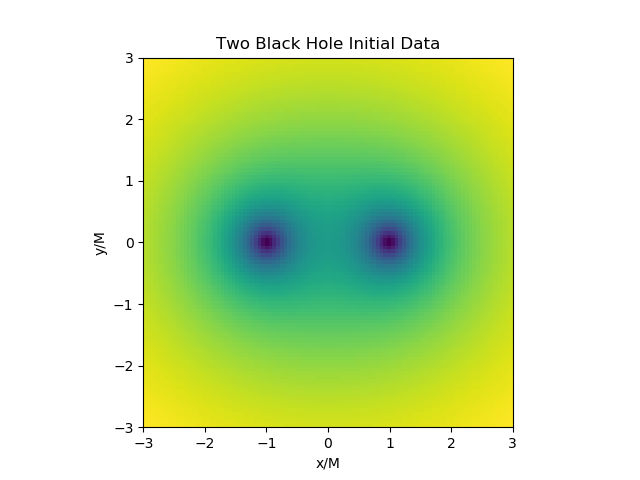

In [16]:
import numpy as np
from scipy.interpolate import griddata
from pylab import savefig
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from IPython.display import Image

x96,y96,valuesCF96,valuesHam96 = np.loadtxt('out96.txt').T #Transposed for easier unpacking

pl_xmin = -3.
pl_xmax = +3.
pl_ymin = -3.
pl_ymax = +3.

grid_x, grid_y = np.mgrid[pl_xmin:pl_xmax:100j, pl_ymin:pl_ymax:100j]
points96 = np.zeros((96*96, 2))
for i in range(96*96):
    points96[i][0] = x96[i]
    points96[i][1] = y96[i]

grid96 = griddata(points96, valuesCF96, (grid_x, grid_y), method='nearest')
grid96cub = griddata(points96, valuesCF96, (grid_x, grid_y), method='cubic')

plt.clf()
plt.title("Two Black Hole Initial Data")
plt.xlabel("x/M")
plt.ylabel("y/M")

# fig, ax = plt.subplots()
# ax.plot(grid96cub.T, extent=(pl_xmin,pl_xmax, pl_ymin,pl_ymax))
# plt.close(fig)
plt.imshow(grid96cub.T, extent=(pl_xmin,pl_xmax, pl_ymin,pl_ymax))
savefig("BHB.png")
from IPython.display import Image
Image("BHB.png")
# #           interpolation='nearest', cmap=cm.gist_rainbow)

## Validation: Convergence of numerical errors (Hamiltonian constraint violation) to zero

The equations behind these initial data solve Einstein's equations exactly, at a single instant in time. One reflection of this solution is that the Hamiltonian constraint violation should be exactly zero in the initial data. 

However, when evaluated on numerical grids, the Hamiltonian constraint violation will *not* generally evaluate to zero due to the associated numerical derivatives not being exact. However, these numerical derivatives (finite difference derivatives in this case) should *converge* to the exact derivatives as the density of numerical sampling points approaches infinity.

In this case, all of our finite difference derivatives agree with the exact solution, with an error term that drops with the uniform gridspacing to the fourth power: $\left(\Delta x^i\right)^4$. 

Here, as in the [Start-to-Finish Scalar Wave (Cartesian grids) NRPy+ tutorial](Tutorial-Start_to_Finish-ScalarWave.ipynb) and the [Start-to-Finish Scalar Wave (curvilinear grids) NRPy+ tutorial](Tutorial-Start_to_Finish-ScalarWaveCurvilinear.ipynb) we confirm this convergence.

First, let's take a look at what the numerical error looks like on the x-y plane at a given numerical resolution, plotting $\log_{10}|H|$, where $H$ is the Hamiltonian constraint violation:

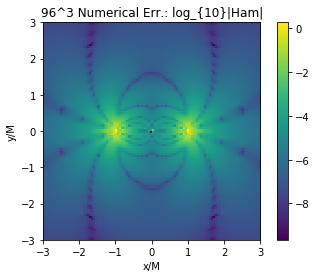

In [17]:
grid96 = griddata(points96, valuesHam96, (grid_x, grid_y), method='nearest')
grid96cub = griddata(points96, valuesHam96, (grid_x, grid_y), method='cubic')

# fig, ax = plt.subplots()

plt.clf()
plt.title("96^3 Numerical Err.: log_{10}|Ham|")
plt.xlabel("x/M")
plt.ylabel("y/M")

fig96cub = plt.imshow(grid96cub.T, extent=(pl_xmin,pl_xmax, pl_ymin,pl_ymax))
cb = plt.colorbar(fig96cub)

Next, we set up the same initial data but on a lower-resolution, $48^3$ grid. Since the constraint violation (numerical error associated with the fourth-order-accurate, finite-difference derivatives) should converge to zero with the uniform gridspacing to the fourth power: $\left(\Delta x^i\right)^4$, we expect the constraint violation will increase (relative to the $96^3$ grid) by a factor of $\left(96/48\right)^4$. Here we demonstrate that indeed this order of convergence is observed as expected. I.e., at all points *except* at the points immediately surrounding the coordinate center of the black hole (due to the spatial slice excising the physical singularity at this point through [the puncture method](http://gr.physics.ncsu.edu/UMD_June09.pdf)) exhibit numerical errors that drop as $\left(\Delta x^i\right)^4$.

<Figure size 432x288 with 0 Axes>

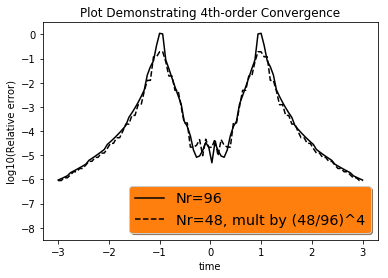

In [18]:
!taskset -c 0,1 ./BSSNCurvilinear_Playground 48 48 48 > out48.txt

x48,y48,valuesCF48,valuesHam48 = np.loadtxt('out48.txt').T #Transposed for easier unpacking
points48 = np.zeros((48*48, 2))
for i in range(48*48):
    points48[i][0] = x48[i]
    points48[i][1] = y48[i]

grid48 = griddata(points48, valuesHam48, (grid_x, grid_y), method='nearest')

griddiff_48_minus_96 = np.zeros((100,100))
griddiff_48_minus_96_1darray = np.zeros(100*100)
gridx_1darray_yeq0 = np.zeros(100)
grid48_1darray_yeq0 = np.zeros(100)
grid96_1darray_yeq0 = np.zeros(100)
count = 0
for i in range(100):
    for j in range(100):
        griddiff_48_minus_96[i][j] = grid48[i][j] - grid96[i][j]
        griddiff_48_minus_96_1darray[count] = griddiff_48_minus_96[i][j]
        if j==49:
            gridx_1darray_yeq0[i] = grid_x[i][j]
            grid48_1darray_yeq0[i] = grid48[i][j] + np.log10((48./96.)**4)
            grid96_1darray_yeq0[i] = grid96[i][j]
        count = count + 1

plt.clf()
fig, ax = plt.subplots()
plt.title("Plot Demonstrating 4th-order Convergence")
plt.xlabel("time")
plt.ylabel("log10(Relative error)")

ax.plot(gridx_1darray_yeq0, grid96_1darray_yeq0, 'k-', label='Nr=96')
ax.plot(gridx_1darray_yeq0, grid48_1darray_yeq0, 'k--', label='Nr=48, mult by (48/96)^4')
ax.set_ylim([-8.5,0.5])

legend = ax.legend(loc='lower right', shadow=True, fontsize='x-large')
legend.get_frame().set_facecolor('C1')
plt.show()